In [1]:
import numpy as np
from collections import OrderedDict
import tensorflow as tf
from tensorflow.contrib.eager.python import tfe

# This silent device placement will hurt performance on GPUs, but we are sticking to CPUs only so it
# should be fine
tf.enable_eager_execution()
tf.set_random_seed(0)

D:\Users\Yue\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Goal
We are going to implement the JANet model from the paper ["The unreasonable effectiveness of the forget gate"](https://arxiv.org/abs/1804.04849) and try the addition experiment to see if it converges properly. 

This is not going to be a high performance model, nor will it probably match the performance of the paper. This is going to be a simple exercise in how easy it is to write down research models in Tensorflow Eager without all the baggage of Tensorflow graphs.

# Components we need
For JANet, we need two components :

1) Chrono Initializer from the paper [Can recurrent neural networks warp time? ](https://openreview.net/forum?id=SJcKhk-Ab)

2) The RNN cell which will do most of the work

Lets create the initializer first since it is simpler

# Chrono Initializer
In short, if we know the length of the sequence in the range $[T_{min}, T_{max}]$, then it would be beneficial to initialize the model with a forgetting time in the same range. Therefore, this would be equivalent to initialize the gate $g$ in the range $[\frac{1}{T_{max}}, \frac{1}{T_{min}}]$.

If the values of both inputs and hidden layers are centered over time, $g(t)$ will typically take values centered around $\sigma(b_g)$. To obtain values in the desired range above, the biases $b_g$ must be in the range $-log(T_{max} - 1)$ and $-log(T_{min} - 1)$.

For the $t$th time step, the forget gate $f_t$ corresponds to $1 - g_t$, where as the input gate $i_t$ corresponds to $g_t$ in an LSTM RNN. Letting the minimum number of timesteps to be 1 and maximum to be $T_{max}$, the paper suggests initializing the forget gate and input gate as follows : 

\begin{align}
b_f &\sim log(U([1, T_{max}]) - 1) \\\
b_i &= -b_f
\end{align}

For a complete explanation of ChronoInitializer, refer to the above paper.


In [2]:
if tfe.num_gpus() > 0:
    _device = '/gpu:0'
else:
    _device = '/cpu:0'

In [3]:
class ChronoInitializer(tf.keras.initializers.RandomUniform):
    """
    Chrono Initializer from the paper :
    [Can recurrent neural networks warp time?](https://openreview.net/forum?id=SJcKhk-Ab)
    """

    def __init__(self, max_timesteps, seed=None):
        super(ChronoInitializer, self).__init__(1., max_timesteps - 1, seed)
        self.max_timesteps = max_timesteps

    def __call__(self, shape, dtype=None, partition_info=None):
        values = super(ChronoInitializer, self).__call__(shape, dtype=dtype, partition_info=partition_info)
        return tf.log(values)

    def get_config(self):
        config = {
            'max_timesteps': self.max_timesteps
        }
        base_config = super(ChronoInitializer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# RNN Cell

The model described in the paper ["The unreasonable effectiveness of the forget gate"](https://arxiv.org/abs/1804.04849) is called JANet - a model where the forget $(g_f)$ gate alone is the one of two gates, alongside with the memory $(g_c)$ gate. It doesn't use the input $(g_i)$ and output $(g_o)$ gates.

In [4]:

class JANETModel(tf.keras.Model):

    def __init__(self, units, num_outputs, num_timesteps, output_activation='sigmoid', **kwargs):
        super(JANETModel, self).__init__(**kwargs)

        self.units = units
        self.classes = num_outputs
        self.num_timesteps = num_timesteps

        # Initialize the forget gate with ChronoInitializer
        # The memory gate is initialized with zeros
        def bias_initializer(_, *args, **kwargs):
            forget_gate = ChronoInitializer(self.num_timesteps)((self.units,), *args, **kwargs)

            return tf.keras.backend.concatenate([
                forget_gate,
                tf.keras.initializers.Zeros()((self.units,), *args, **kwargs),
            ])

            # Initialize the hidden and recurrent gates
        self.kernel = tf.keras.layers.Dense(2 * units, use_bias=False,
                                            kernel_initializer='glorot_uniform')

        self.recurrent_kernel = tf.keras.layers.Dense(2 * units,
                                                      kernel_initializer='glorot_uniform',
                                                      bias_initializer=bias_initializer)

        # Initialize the final layer (for classification or regression depending on the output activation)
        self.output_dense = tf.keras.layers.Dense(num_outputs, activation=output_activation)
        
    """
    This is required to override a certain issue with how the weights of a model are loaded
    by a checkpoint.
    
    While we could use `model.call(inputs)` directly, the more pythonic way of doing this is
    by using `model(inputs)`.
    
    However, in Eager mode, the ordinary function call does *not* forward the method to the
    models `call` method. This bypasses that issue.
    """
    def __call__(self, *args, **kwargs):
        if not tf.executing_eagerly():
            super(JANETModel, self).__call__(*args, **kwargs)
        return self.call(*args, **kwargs)

    def call(self, inputs, training=None, mask=None):
        # Initialize the hidden memory states
        outputs = []
        states = []
        
        h_state = tf.zeros((inputs.shape[0], self.units))
        c_state = tf.zeros((inputs.shape[0], self.units))
        
        # Input is in the shape [None, timesteps, input_dim]
        for t in range(inputs.shape[1]):
            ip = inputs[:, t, :]  # access the T'th timestep

            # Perform the forward pass of the model
            z = self.kernel(ip)
            z += self.recurrent_kernel(h_state)

            # Split the output into the forget and memory outputs
            z0 = z[:, :self.units]
            z1 = z[:, self.units: 2 * self.units]

            # gate updates
            f = tf.keras.activations.sigmoid(z0)
            c = f * c_state + (1. - f) * tf.nn.tanh(z1)

            # state updates
            h = c

            # update our previous state
            h_state = h
            c_state = c

            # preserve the history of our states
            outputs.append(h)
            states.append([h, c])  # here we maintain just 1 state variable, can be more

        # save memory states to global variables so we can access them later
        # self.cell_outputs = tf.stack(outputs, axis=1)
        # self.cell_states = states

        # perform forward pass of the classifier / regressor
        preds = self.output_dense(outputs[-1])

        return preds


# Setup
In Eager, if you use only tf.keras layers, then training is a lot simpler. You can simply call the .fit and .predict methods after compiling the models. This is what we will not do for the current model, even though we could, as it is important to explain the limitations of sticking to models with only Keras layers.

We will declare some helper methods, along with the dataset loader. Since the addition task is simple enough, we will not be using the canonical way to load data - tf.data pipeline. For this dataset in which we generate synthetic data, the overhead of the tf.data pipeline is more than the benefit.

In [5]:
# we define some constants 
import os
if not os.path.exists('weights'):
    os.makedirs('weights/')

# Parameters taken from https://arxiv.org/abs/1804.04849
TIME_STEPS = 100
NUM_UNITS = 128
LEARNING_RATE = 0.001
STEPS_PER_EPOCH = 100
NUM_EPOCHS = 10
BATCH_SIZE = 50

CHECKPOINTS_DIR = 'checkpoints_addition/'
CHECKPOINT_PATH = CHECKPOINTS_DIR + 'addition_janet.ckpt'


# Addition Dataset Generator

In [6]:
# Code reused from https://github.com/batzner/indrnn/blob/master/examples/addition_rnn.py
# with some modifications to run on Tensorflow Eager mode


def batch_generator():
    while True:
        """Generate the adding problem dataset"""
        # Build the first sequence
        add_values = np.random.rand(BATCH_SIZE, TIME_STEPS)

        # Build the second sequence with one 1 in each half and 0s otherwise
        add_indices = np.zeros_like(add_values, dtype='float32')
        half = int(TIME_STEPS / 2)
        for i in range(BATCH_SIZE):
            first_half = np.random.randint(half)
            second_half = np.random.randint(half, TIME_STEPS)
            add_indices[i, [first_half, second_half]] = 1.

        # Zip the values and indices in a third dimension:
        # inputs has the shape (batch_size, time_steps, 2)
        inputs = np.dstack((add_values, add_indices))
        targets = np.sum(np.multiply(add_values, add_indices), axis=1)
        targets = np.expand_dims(targets, -1)

        # center at zero mean
        inputs -= np.mean(inputs, axis=0, keepdims=True)
        
        inputs = tf.constant(inputs, dtype=tf.float32)
        targets = tf.constant(targets, dtype=tf.float32)

        yield inputs, targets


# Loss and Gradients
The following functions simply compute the mean squared error, and compute the gradients of the model.

In [7]:
def loss(y_true, y_pred):
    loss_val = tf.losses.mean_squared_error(y_true, y_pred)
    return loss_val


def grad(model, X, y):
    with tf.GradientTape() as tape:
        preds = model(X)
        loss_val = loss(y, preds)
        
    vars = model.trainable_variables 
    grads = tape.gradient(loss_val, vars)
    grad_vars = zip(grads, vars)

    return grad_vars, loss_val

# Training and Checkpointing

In [12]:
import shutil

with tf.device(_device):
    model = JANETModel(NUM_UNITS, num_outputs=1, num_timesteps=TIME_STEPS, output_activation='linear')

    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
    global_step = tf.train.get_or_create_global_step()
    
    generator = batch_generator()

# try using different optimizers and different optimizer configs
# model.compile(loss='mse', optimizer=optimizer)

best_loss = 100.

loss_history = []
update_counter = 1

for epoch in range(NUM_EPOCHS):
    print("Epoch # : ", epoch + 1)

    for step in range(STEPS_PER_EPOCH):
        # get batch dataset
        with tf.device(_device):
            inputs, targets = next(generator)

            # get gradients and loss at this iteration
            gradients, loss_val = grad(model, inputs, targets)

            # apply gradients
            optimizer.apply_gradients(gradients, tf.train.get_or_create_global_step())

        loss_history.append(loss_val.numpy())
        print(update_counter, ":", loss_history[-1])

        update_counter += 1
    print()

    # remove old checkpoint that we no longer need
    if os.path.exists(CHECKPOINTS_DIR):
        shutil.rmtree(CHECKPOINTS_DIR)

    # save the checkpoint weights
    checkpoint = tfe.Checkpoint(model=model).save(CHECKPOINT_PATH)

    # Optional : Save the weight matrices in Keras format as well
    # model.save_weights('addition_model.h5', overwrite=True)

    print("Saving weights")
    print()


Epoch # :  1
1 : 1.4451375
2 : 1.2100395
3 : 1.0465797
4 : 1.1592366
5 : 0.89892256
6 : 0.95416474
7 : 0.76734453
8 : 0.8083082
9 : 0.5987345
10 : 0.43943503
11 : 0.36136585
12 : 0.1923017
13 : 0.20704773
14 : 0.31842035
15 : 0.32538295
16 : 0.23726974
17 : 0.2102163
18 : 0.17351742
19 : 0.15244175
20 : 0.17523283
21 : 0.27364022
22 : 0.2666938
23 : 0.21667854
24 : 0.20420966
25 : 0.21706091
26 : 0.13949679
27 : 0.22169092
28 : 0.14021274
29 : 0.13293959
30 : 0.13264558
31 : 0.14265671
32 : 0.18486334
33 : 0.17616434
34 : 0.19732943
35 : 0.18540621
36 : 0.20976181
37 : 0.16762428
38 : 0.15358415
39 : 0.09938493
40 : 0.16012174
41 : 0.1352579
42 : 0.13615915
43 : 0.19032782
44 : 0.21800873
45 : 0.120117724
46 : 0.19352394
47 : 0.12246391
48 : 0.16440761
49 : 0.18718316
50 : 0.15584385
51 : 0.18077189
52 : 0.20388669
53 : 0.16069853
54 : 0.12863132
55 : 0.1536328
56 : 0.14860286
57 : 0.14560589
58 : 0.19622646
59 : 0.123918116
60 : 0.15879595
61 : 0.11481209
62 : 0.17653896
63 : 0.132569

486 : 0.10114731
487 : 0.104497984
488 : 0.14274797
489 : 0.160999
490 : 0.13257213
491 : 0.1433788
492 : 0.08464967
493 : 0.12354956
494 : 0.09862904
495 : 0.1193639
496 : 0.12384308
497 : 0.10837276
498 : 0.15399057
499 : 0.14242369
500 : 0.11715834

Saving weights

Epoch # :  6
501 : 0.13442406
502 : 0.122542895
503 : 0.096438885
504 : 0.11270418
505 : 0.12368342
506 : 0.15054221
507 : 0.11291506
508 : 0.08080871
509 : 0.09131373
510 : 0.08952438
511 : 0.11494467
512 : 0.09245553
513 : 0.10379431
514 : 0.074560665
515 : 0.07031863
516 : 0.079880826
517 : 0.091697544
518 : 0.08455921
519 : 0.07518372
520 : 0.093540765
521 : 0.073418446
522 : 0.05932852
523 : 0.08722296
524 : 0.084686145
525 : 0.068582505
526 : 0.053134985
527 : 0.08068697
528 : 0.06336024
529 : 0.048133183
530 : 0.06521394
531 : 0.0921517
532 : 0.066156454
533 : 0.070156984
534 : 0.06810923
535 : 0.07680989
536 : 0.05213432
537 : 0.06263829
538 : 0.06623813
539 : 0.05790771
540 : 0.06402144
541 : 0.065428525
542 : 0.

941 : 0.012369012
942 : 0.013733639
943 : 0.015813028
944 : 0.014613378
945 : 0.0108814025
946 : 0.017073147
947 : 0.012277768
948 : 0.011523608
949 : 0.010260019
950 : 0.0105614625
951 : 0.010187719
952 : 0.012835086
953 : 0.008723493
954 : 0.011253092
955 : 0.0161443
956 : 0.0138244815
957 : 0.016399836
958 : 0.012679138
959 : 0.010885792
960 : 0.015541065
961 : 0.021089569
962 : 0.009084817
963 : 0.015007372
964 : 0.017662758
965 : 0.010010967
966 : 0.00870137
967 : 0.014901962
968 : 0.009409742
969 : 0.01382525
970 : 0.012637113
971 : 0.022212887
972 : 0.012161435
973 : 0.025501728
974 : 0.010741842
975 : 0.010838392
976 : 0.012944105
977 : 0.01013847
978 : 0.011446202
979 : 0.0132047795
980 : 0.015261328
981 : 0.010831416
982 : 0.009888933
983 : 0.012245169
984 : 0.009549674
985 : 0.008401048
986 : 0.011405158
987 : 0.009189022
988 : 0.012930982
989 : 0.0069505097
990 : 0.015047225
991 : 0.009100561
992 : 0.00910202
993 : 0.0137563525
994 : 0.008319947
995 : 0.010955427
996 : 0.00

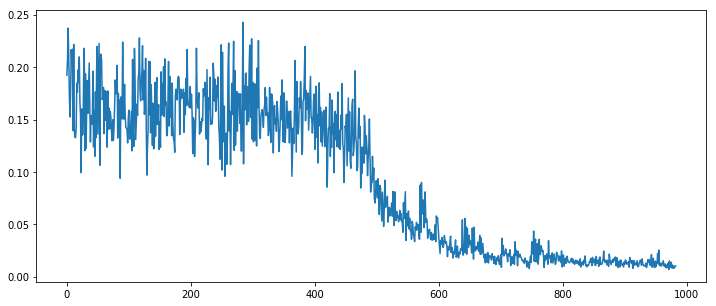

In [13]:
import matplotlib.pyplot as plt

# remove noise from initial epochs
loss_history_plot = list(filter(lambda x: x < 0.25, loss_history))

plt.figure(figsize=(12, 5))
plt.plot(loss_history_plot)
plt.show()

# Observations
The model does train for 100 timesteps quite quickly, but it doesnt match the speed of learning by the paper. In the paper, the loss starts to drop close to the 300th iteration and drops all the way to the low 0.0x by the 425th iteration.

Here the loss starts to reduce at the 400th iteration and drops completely by the 600th iteration, much slower than the paper. Also, I had to clip off the first few iterations with extremely high losses as the graph cannot be visualized properly if they were kept.

#  Loading Checkpoints

Tensorflow Eager makes loading of checkpoints that are fully contained in a Keras model easy. However, there is one small idiosynchacy that needs to be dealt with when loading models in TF 1.7.

Models, after being build, need to be called at least once prior to the checkpoint restoring their weights. If this is not done, it throws obscure errors.

In [14]:
if os.path.exists(CHECKPOINTS_DIR):
    ckpt_path = tf.train.latest_checkpoint(CHECKPOINTS_DIR)
    print("Checkpoint path : ", ckpt_path)
    
    with tf.device(_device):
        model = JANETModel(NUM_UNITS, num_outputs=1, num_timesteps=TIME_STEPS, output_activation='linear')

        # model.compile(tf.train.AdamOptimizer(), loss='mse')
    
        # this is where you need to call the model at least once,
        # so that all of its variables can be properly restored
        zeros = tf.zeros((1, TIME_STEPS, 2))
        model(zeros)
    
        # restore the weights
        tfe.Checkpoint(model=model, ).restore(ckpt_path)

        # predict one batch to ensure the weights are correctly loaded
        generator = batch_generator()

        losses = []
        for i in range(20):
            inputs, outputs = next(generator)

            preds = model(inputs)
            loss_val = loss(outputs, preds)

            losses.append(loss_val.numpy())

    print("Final average predicted error (should be less than 0.03) : ", np.mean(losses))

Checkpoint path :  checkpoints_addition/addition_janet.ckpt-1
Final average predicted error (should be less than 0.03) :  0.010359424


# Stepping off the well trodden path
When building keras models that **only** use Keras layers, there is no issue when loading or saving weights.

However, not every thing can be represented in layers, and a few models may require working directlty with TF Eager variables. In such cases, a different approach is required to save and restore these models.

Lets see the same model without using Keras layers to define them. Here to keep it simple, we will use Eager variables to define the RNN cell, and a Keras Layer to define the classification / regression layer.

In [15]:
class EagerJANETModel(tf.keras.Model):
    
    def __init__(self, input_dim, units, num_outputs, num_timesteps, output_activation='sigmoid', **kwargs):
        super(EagerJANETModel, self).__init__(**kwargs)
        
        self.input_dim = input_dim
        self.units = units
        self.classes = num_outputs
        self.num_timesteps = num_timesteps

        # Initialize the forget gate with ChronoInitializer
        # The memory gate is initialized with zeros
        def bias_initializer(_, *args, **kwargs):
            forget_gate = ChronoInitializer(self.num_timesteps)((self.units,), *args, **kwargs)
                
            return tf.keras.backend.concatenate([
                forget_gate,
                tf.keras.initializers.Zeros()((self.units,), *args, **kwargs),
            ])
            
        # Initialize the hidden and recurrent gates
        self.kernel = tf.get_variable('kernel', shape=[input_dim, units * 2], dtype=tf.float32,
                                     initializer=tf.keras.initializers.glorot_uniform())
            
        self.recurrent_kernel = tf.get_variable('recurrent_kernel', shape=[units, units * 2], dtype=tf.float32,
                                                initializer=tf.keras.initializers.glorot_uniform())
            
        self.recurrent_bias = tf.get_variable('recurrent_bias', shape=[units * 2], dtype=tf.float32,
                                              initializer=bias_initializer)
            
        # Initialize the final layer (for classification or regression depending on the output activation)
        self.output_dense = tf.keras.layers.Dense(num_outputs, activation=output_activation)
        
        # we need to create a dictionary of all of the weights which are not in Keras layers
        self.additional_weights = OrderedDict()
        self.additional_weights[self.kernel.name] = self.kernel
        self.additional_weights[self.recurrent_kernel.name] = self.recurrent_kernel
        self.additional_weights[self.recurrent_bias.name] = self.recurrent_bias
        
    
    """
    This is required to override a certain issue with how the weights of a model are loaded
    by a checkpoint.
    
    While we could use `model.call(inputs)` directly, the more pythonic way of doing this is
    by using `model(inputs)`.
    
    However, in Eager mode, the ordinary function call does *not* forward the method to the
    models `call` method. This bypasses that issue.
    """
    def __call__(self, *args, **kwargs):
        if not tf.executing_eagerly():
            super(EagerJANETModel, self).__call__(*args, **kwargs)
        return self.call(*args, **kwargs)

    def call(self, inputs, training=None, mask=None):
        # Initialize the hidden memory states
        outputs = []
        states = []
        
        h_state = tf.zeros((inputs.shape[0], self.units))
        c_state = tf.zeros((inputs.shape[0], self.units))
            
        # Input is in the shape [None, timesteps, input_dim]
        for t in range(inputs.shape[1]):
            ip = inputs[:, t, :]  # access the T'th timestep
                
            # Perform the forward pass of the model
            z = tf.matmul(ip, self.kernel)
            z += tf.matmul(h_state, self.recurrent_kernel) + self.recurrent_bias
                
            # Split the output into the forget and memory outputs
            z0 = z[:, :self.units]
            z1 = z[:, self.units: 2 * self.units]
    
            # gate updates
            f = tf.keras.activations.sigmoid(z0)
            c = f * c_state + (1. - f) * tf.nn.tanh(z1)
    
            # state updates
            h = c
                
            # update our previous state
            h_state = h
            c_state = c
            
            # preserve the history of our states
            outputs.append(h)
            states.append([h])  # here we maintain just 1 state variable, can be more
                
        # save memory states to global variables so we can access them later
        # self.cell_outputs = tf.stack(outputs, axis=1)
        # self.cell_states = states
            
        # perform forward pass of the classifier / regressor
        preds = self.output_dense(outputs[-1])

        return preds

# Gradients of a custom model

The gradients of such a model are a little more complicated than the earlier simple `model.trainable_variables`. Since tf.keras Models do not track the weights that are added separately (apart from keras layers, no weights or variables are managed by Keras), we need to write a custom grad function.

In [16]:
def grad(model, X, y):
    with tf.GradientTape() as tape:
        preds = model(X)
        loss_val = loss(y, preds)
        
    # this is the crucial step : use the dictionary of weights that we manage
    # manually to get all of the weights that are not managed by keras and add
    # them to the list of weights for which we need gradients
    vars = model.trainable_variables + list(model.additional_weights.values())
    grads = tape.gradient(loss_val, vars)
    grad_vars = zip(grads, vars)

    return grad_vars, loss_val

# Reason for custom gradient function

Keras has two very convenient methods `add_weight` and `add_variable` to add weights to a layer / model easily. However, TF Eager mode has not implemented these methods yet, and therefore we cant use them directly.

Therefore, we have to take the roundabout way of mixing Keras layers with custom weights and keep a track of them using a dictionary.

# Training and Saving the weights of a custom model

Saving and restoring of custom models is exactly the same as before if you are using tf.get_variable to create variables in Eager mode. However, tfe.Variable() is NOT managed by keras, so don't use it inside a Keras model.

In [17]:
%%time
input_dim = 2

with tf.device(_device):
    model = EagerJANETModel(input_dim, NUM_UNITS, num_outputs=1, num_timesteps=TIME_STEPS, output_activation='linear')

    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
    global_step = tf.train.get_or_create_global_step()

    # try using different optimizers and different optimizer configs
    # model.compile(loss='mse', optimizer=optimizer)

    best_loss = 100.
    generator = batch_generator()

loss_history = []
update_counter = 1

for epoch in range(NUM_EPOCHS):
    print("Epoch # : ", epoch + 1)

    for step in range(STEPS_PER_EPOCH):
        # get batch dataset
        with tf.device(_device):
            inputs, targets = next(generator)

            # get gradients and loss at this iteration (uses the new grad method)
            gradients, loss_val = grad(model, inputs, targets)

            # apply gradients
            optimizer.apply_gradients(gradients, tf.train.get_or_create_global_step())

        loss_history.append(loss_val.numpy())
        print(update_counter, ":", loss_history[-1])

        update_counter += 1

    print()

    # remove old checkpoint that we no longer need
    if os.path.exists(CHECKPOINTS_DIR):
        shutil.rmtree(CHECKPOINTS_DIR)

    # save the checkpoint weights
    # Note how we add the model's additional weights as name-variable pairs
    checkpoint = tfe.Checkpoint(model=model).save(CHECKPOINT_PATH)

    # Optional : Save the weight matrices in Keras format as well
    #model.save_weights('addition_model.h5', overwrite=True)

    print("Saving weights")
    print()
print()


Epoch # :  1
1 : 1.1070119
2 : 1.1105163
3 : 0.8818216
4 : 1.0917069
5 : 0.77383345
6 : 1.0805733
7 : 0.83379626
8 : 0.7731505
9 : 0.55083674
10 : 0.54209757
11 : 0.28447378
12 : 0.22762008
13 : 0.13934982
14 : 0.20197843
15 : 0.39939064
16 : 0.31061924
17 : 0.15716037
18 : 0.18323703
19 : 0.13392271
20 : 0.13464299
21 : 0.276382
22 : 0.17964411
23 : 0.22904907
24 : 0.21105047
25 : 0.26379216
26 : 0.20097953
27 : 0.1950277
28 : 0.21655178
29 : 0.26505485
30 : 0.20399876
31 : 0.17650402
32 : 0.16045463
33 : 0.17143913
34 : 0.14122799
35 : 0.20478329
36 : 0.18234424
37 : 0.23561493
38 : 0.17591843
39 : 0.17281689
40 : 0.15329581
41 : 0.16284627
42 : 0.17922379
43 : 0.10488374
44 : 0.19159271
45 : 0.18599848
46 : 0.13775517
47 : 0.20575161
48 : 0.2778363
49 : 0.18510982
50 : 0.16983838
51 : 0.19744366
52 : 0.13969105
53 : 0.18370225
54 : 0.14061068
55 : 0.1928698
56 : 0.17589724
57 : 0.2265582
58 : 0.1547241
59 : 0.12760934
60 : 0.19300795
61 : 0.18235433
62 : 0.1795494
63 : 0.17900254
64

486 : 0.14468968
487 : 0.083180495
488 : 0.06987886
489 : 0.097393304
490 : 0.073100865
491 : 0.11486647
492 : 0.09194204
493 : 0.0654128
494 : 0.08316186
495 : 0.11223145
496 : 0.07783792
497 : 0.12735291
498 : 0.06786843
499 : 0.10243812
500 : 0.06703848

Saving weights

Epoch # :  6
501 : 0.07971802
502 : 0.064800866
503 : 0.11394337
504 : 0.065818876
505 : 0.0714549
506 : 0.08406609
507 : 0.05725936
508 : 0.07875797
509 : 0.061405696
510 : 0.063146144
511 : 0.07170342
512 : 0.050907765
513 : 0.054377183
514 : 0.059061203
515 : 0.05365225
516 : 0.07325519
517 : 0.064301625
518 : 0.07002276
519 : 0.09850267
520 : 0.05637608
521 : 0.116176955
522 : 0.070346825
523 : 0.0635022
524 : 0.10820709
525 : 0.077265136
526 : 0.046696614
527 : 0.082699515
528 : 0.07663349
529 : 0.05269104
530 : 0.06779609
531 : 0.07755826
532 : 0.06394911
533 : 0.08462149
534 : 0.061114777
535 : 0.049828798
536 : 0.06738005
537 : 0.082841374
538 : 0.07510481
539 : 0.06940232
540 : 0.06893617
541 : 0.08840316
54

942 : 0.016636811
943 : 0.017222516
944 : 0.009324293
945 : 0.009084051
946 : 0.0143687315
947 : 0.010870088
948 : 0.012142699
949 : 0.016324442
950 : 0.009925196
951 : 0.0100024
952 : 0.0126454355
953 : 0.0146793565
954 : 0.013418141
955 : 0.013895083
956 : 0.01397774
957 : 0.013729873
958 : 0.015033621
959 : 0.015328206
960 : 0.019933945
961 : 0.014806671
962 : 0.018491514
963 : 0.017737335
964 : 0.013863844
965 : 0.013754041
966 : 0.018179528
967 : 0.013488879
968 : 0.013930746
969 : 0.008715766
970 : 0.007628554
971 : 0.016496891
972 : 0.012624218
973 : 0.0097497795
974 : 0.014186646
975 : 0.01849011
976 : 0.013620214
977 : 0.016832981
978 : 0.0137945535
979 : 0.016127512
980 : 0.0133153675
981 : 0.009538996
982 : 0.014279413
983 : 0.012188692
984 : 0.008317082
985 : 0.014955339
986 : 0.015025271
987 : 0.016098987
988 : 0.011772374
989 : 0.017549185
990 : 0.013207734
991 : 0.013621126
992 : 0.011447512
993 : 0.012098037
994 : 0.014460028
995 : 0.01570248
996 : 0.012644585
997 : 0.0

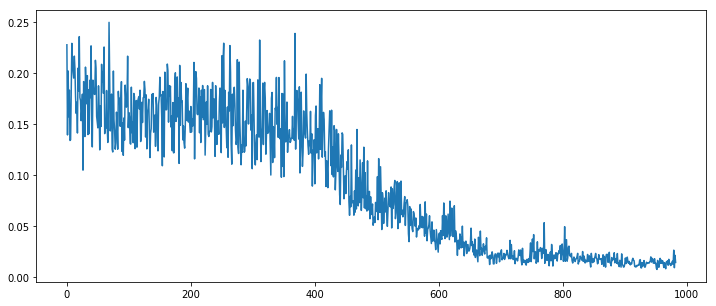

In [18]:
# remove noise from initial epochs
loss_history_plot = list(filter(lambda x: x < 0.25, loss_history))

plt.figure(figsize=(12, 5))
plt.plot(loss_history_plot)

# Restoring custom models

Because of the added complexity of saving hybrid models, we need to have a slightly different method to load the weights of the custom model from the checkpoint.

In [19]:
if os.path.exists(CHECKPOINTS_DIR):
    ckpt_path = tf.train.latest_checkpoint(CHECKPOINTS_DIR)
    print("Checkpoint path : ", ckpt_path)
    
    with tf.device(_device):
        model = EagerJANETModel(input_dim, NUM_UNITS, num_outputs=1, num_timesteps=TIME_STEPS, output_activation='linear')

        # model.compile(tf.train.AdamOptimizer(), loss='mse')

        # this is where you need to call the model at least once,
        # so that all of its variables can be properly restored
        zeros = tf.zeros((1, TIME_STEPS, 2))
        model(zeros)

        # restore the weights
        # see the difference as to how we pass the additional weight matrices to be loaded
        tfe.Checkpoint(model=model).restore(ckpt_path)

        # predict one batch to ensure the weights are correctly loaded
        generator = batch_generator()

        losses = []
        for i in range(20):
            inputs, outputs = next(generator)

            preds = model(inputs)
            loss_val = loss(outputs, preds)

            losses.append(loss_val.numpy())

    print("Final average predicted error (should be less than 0.03) : ", np.mean(losses))

Checkpoint path :  checkpoints_addition/addition_janet.ckpt-1
Final average predicted error (should be less than 0.03) :  0.012852971
